In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.models import Model
from PIL import Image
import numpy as np
import PIL.Image
import time
import functools

### Load Image

In [2]:
style_path = "/content/Vincent_van_Gogh_1.jpg"
base_path = "/content/Camille_Pissarro_1.jpg"

In [3]:
# Dimensions of the generated picture.
width, height = load_img(base_path).size
img_height = 400
img_width = int(width * img_height / height)

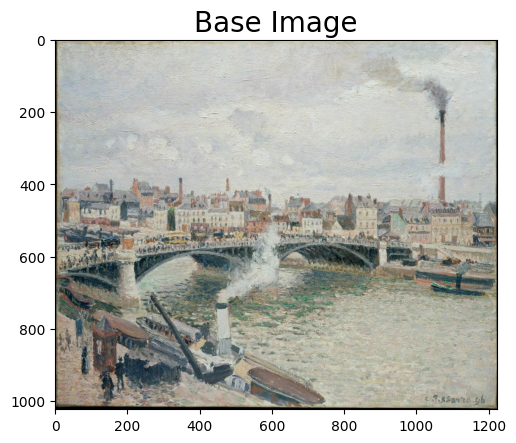

In [4]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_path)
plt.imshow(img1)

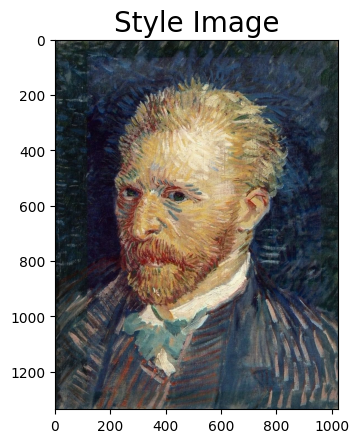

In [5]:
plt.figure()
plt.title("Style Image",fontsize=20)
img2 = load_img(style_path)
plt.imshow(img2)

### Create Function to deprocess image

In [6]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

### load image and limit max dimension

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [8]:
base_image = load_img(base_path)
style_image = load_img(style_path)

### Define HyperParameters

In [9]:
# Weights of the different loss components
style_weight=1e-2
content_weight=1e4

### Load VGG 19 without classification head

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


choose content layer and style layer

In [11]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Build Model

In [12]:
def get_model(layer_names):
  # Build a VGG19 model loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(weights = 'imagenet', include_top = False)
    model.trainable = False
    # Get the symbolic outputs of each "key" layer
    outputs_dict = [model.get_layer(name).output for name in layer_names]

    # Set up a model that returns the activation values for every layer in VGG19 (as a dict).
    return tf.keras.Model(inputs = [model.inputs], outputs = outputs_dict)

### Create Function for Gram Matrix

In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Extract Style and content

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = get_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs * 255.0)
        outputs = self.vgg(inputs)

        style_outputs = [gram_matrix(style_output) for style_output in outputs[:self.num_style_layers]]
        content_dict = {name: value for name, value in zip(self.content_layers, outputs[self.num_style_layers:])}
        style_dict = {name: value for name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

### Define Loss Functions

In [16]:
def style_loss(style_outputs):
    loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    loss *= style_weight / num_style_layers
    return loss

def content_loss(content_outputs):
    loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    loss *= content_weight / num_content_layers
    return loss

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss_val = style_loss(style_outputs)
    content_loss_val = content_loss(content_outputs)

    loss = style_loss_val + content_loss_val
    return loss

### Training

Set style and content target values

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(base_image)['content']

In [18]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

define optimizer

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.98, epsilon=1e-1)

define training function, add a regularization term for high frequency component of the image

In [20]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [21]:
import IPython.display as display
iter = 1000
def train_and_get_image(image):
    step = 0

    for n in range(iter):
        step += 1
        train_step(image)

    return tensor_to_image(image)

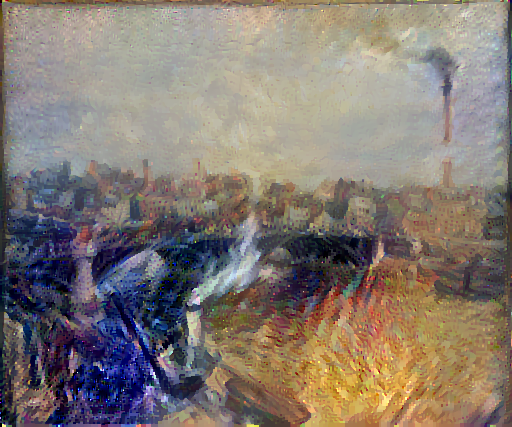

In [22]:
image = tf.Variable(base_image)
display.display(train_and_get_image(image))